In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def gen_curve(offset, scale, noise=200, decay=False):
    base = scale * (1 - np.exp(-timesteps / 4e4)) + offset
    if decay:
        base *= (1 - 0.1 * np.sin(timesteps / 2e4))
    return base + np.random.normal(0, noise, size=timesteps.shape)


def compressor(run, sens=15, episodes=60):
    run_copy = np.copy(run)
    for _ in range(episodes):
        for i in range(1, run_copy.shape[0]-1):
            min_val = min(run_copy[i-1],run_copy[i+1])
            #max_val = max(run[i-1],run[i+1])
            if run_copy[i] <= min_val*sens:
                run_copy[i] = np.mean([run_copy[i-1],run_copy[i+1]])
    return run_copy

# STAGE 1 

In [ ]:
# === Путь к логам ===
log_4k_1 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/HalfCheetah-v4/[STAGE1_POMDP_LSTM]|seed=1|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=10000'
log_4k_2 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/HalfCheetah-v4/[STAGE1_POMDP_LSTM]|seed=2|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=10000'

# === Чтение каждого лога ===
ea_4k_1 = EventAccumulator(log_4k_1); ea_4k_1.Reload()
ea_4k_2 = EventAccumulator(log_4k_2); ea_4k_2.Reload()

# === Список тегов ===
tags = ['LSTM_Eval_reward', 'Trans_Eval_reward']

def get_vals(ea, tag):
    events = ea.Scalars(tag)
    steps = np.array([e.step for e in events])
    vals = np.array([e.value for e in events])
    return steps, vals



ValueError: operands could not be broadcast together with shapes (98,) (99,) 

In [ ]:
# # === Параметры сглаживания ===
# sens = 5
# episodes = 7

# # === Обработка каждого тега ===
# results = {}

# for tag in tags:
#     s1, v1 = get_vals(ea_4k_1, tag)
#     s2, v2 = get_vals(ea_4k_2, tag)

#     v1 = compressor(v1, sens=sens, episodes=episodes)
#     v2 = compressor(v2, sens=sens, episodes=episodes)

#     mean = (v1 + v2) / 2
#     std = np.abs(v1 - v2) / 2

#     results[tag] = {
#         'steps': s1,    # предполагаем, что шаги одинаковы
#         'mean': mean,
#         'std': std
#     }

In [50]:
lstm_t_1, lstm_r_1 = get_vals(ea_4k_1, 'LSTM_Eval_reward')
lstm_t_2, lstm_r_2 = get_vals(ea_4k_2, 'LSTM_Eval_reward')


tr_t_1, tr_r_1 = get_vals(ea_4k_1, 'Trans_Eval_reward')
tr_t_2, tr_r_2 = get_vals(ea_4k_2, 'Trans_Eval_reward')


In [33]:
lstm_r_1.shape , lstm_r_2.shape, tr_r_1.shape, tr_r_2.shape

((98,), (99,), (98,), (99,))

In [49]:
# === Параметры сглаживания ===
sens = 1
episodes = 1

lstm_r_1 = compressor(lstm_r_1, sens=sens, episodes=episodes)
lstm_r_2 = compressor(lstm_r_2, sens=sens, episodes=episodes)
    
tr_r_1 = compressor(tr_r_1, sens=sens*100, episodes=episodes*100)
tr_r_2 = compressor(tr_r_2, sens=sens*100, episodes=episodes*100)

In [51]:
lstm_mean = (lstm_r_1 + lstm_r_2[1:]) / 2
lstm_std = np.abs(lstm_r_1 - lstm_r_2[1:]) / 2

tr_mean = (tr_r_1 + tr_r_2[1:]) / 2
tr_std = np.abs(tr_r_1 - tr_r_2[1:]) / 2

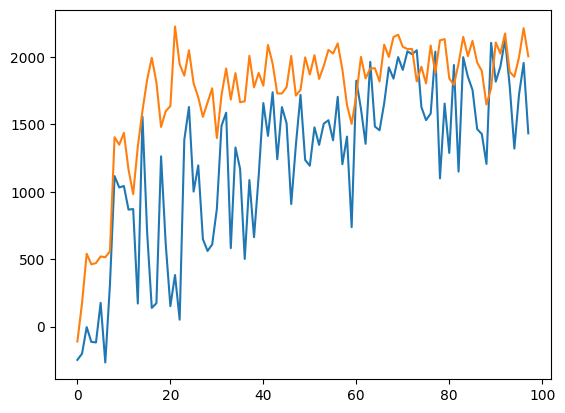

In [52]:
plt.plot(tr_mean)
plt.plot(lstm_mean)

In [58]:
tr_std = tr_std*0.5
lstm_std = lstm_std*0.5

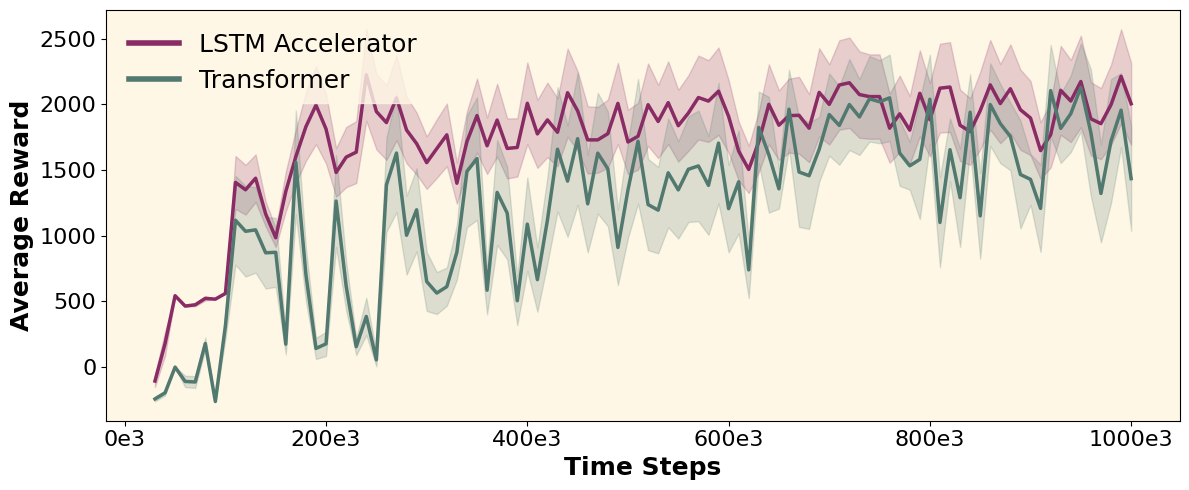

In [68]:
# ========= Отрисовка графика ============
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('#fff7e6')

# MDP_PRETRAINED (сплошные линии)
line1, = ax.plot(lstm_t_1, lstm_mean, label='LSTM Accelerator', color='#892b64', linewidth=2.5)
ax.fill_between(lstm_t_1, lstm_mean - lstm_std, lstm_mean + lstm_std, color='#892b64', alpha=0.2)

line2, = ax.plot(lstm_t_1, tr_mean, label='Transformer', color='#52796f', linewidth=2.5)
ax.fill_between(lstm_t_1, tr_mean - tr_std, tr_mean + tr_std, color='#52796f', alpha=0.2)

# ===== Оформление графика =====
ax.set_xlabel("Time Steps", fontsize=18, weight='bold')
ax.set_ylabel("Average Reward", fontsize=18, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x/1e3)}e3"))

# Легенда без рамки, с увеличенным шрифтом и жирными линиями
legend = ax.legend(
    handles=[
        plt.Line2D([0], [0], color='#892b64', linewidth=4, label='LSTM Accelerator'),
        plt.Line2D([0], [0], color='#52796f', linewidth=4, label='Transformer')
    ],
    loc='upper left',
    fontsize=18,
    frameon=True
)
legend.get_frame().set_facecolor('#fff7e6')
legend.get_frame().set_edgecolor('#fff7e6')  # Цвет рамки как у фона, чтобы была "невидимой"

plt.tight_layout()
plt.show()

# STAGE 2

In [5]:
# === Путь к логам ===
tr1 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/HalfCheetah-v4/[STAGE2_POMDP_LSTM]|seed=1|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=10000'
tr2 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/HalfCheetah-v4/[STAGE2_POMDP_LSTM]|seed=2|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=10000'

lstm1 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/HalfCheetah-v4/[STAGE1_POMDP_LSTM]|seed=1|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=10000'
lstm2 = '/home/daniil/Рабочий стол/Accelerator/RLC_RUNS/HalfCheetah-v4/[STAGE1_POMDP_LSTM]|seed=2|AddAsc=None|AddBell=None|UseTrData=False|EvFreq=10000'

mlp1 = 'FIG4_RUNS[FINAL_MLP_POMDP]/HalfCheetah-v4/seed=1'
mlp2 = 'FIG4_RUNS[FINAL_MLP_POMDP]/HalfCheetah-v4/seed=2'

# === Чтение каждого лога ===
tr1 = EventAccumulator(tr1); tr1.Reload()
tr2 = EventAccumulator(tr2); tr2.Reload()

lstm1 = EventAccumulator(lstm1); lstm1.Reload()
lstm2 = EventAccumulator(lstm2); lstm2.Reload()

mlp1 = EventAccumulator(mlp1); mlp1.Reload()
mlp2 = EventAccumulator(mlp2); mlp2.Reload()
# === Список тегов ===
tags1 = ['Eval_reward']
tags2 = ['LSTM_Eval_reward']

def get_vals(ea, tag):
    events = ea.Scalars(tag)
    steps = np.array([e.step for e in events])
    vals = np.array([e.value for e in events])
    return steps, vals


In [6]:

tr1_s, tr1_v = get_vals(tr1, 'Eval_reward')
tr2_s, tr2_v = get_vals(tr2, 'Eval_reward')

lstm1_s, lstm1_v = get_vals(lstm1, 'LSTM_Eval_reward')
lstm2_s, lstm2_v = get_vals(lstm2, 'LSTM_Eval_reward')

mlp1_s, mlp1_v = get_vals(mlp1, 'Eval_reward')
mlp2_s, mlp2_v = get_vals(mlp2, 'Eval_reward')




In [8]:
tr1_v.shape, tr2_v.shape,      lstm1_v.shape, lstm2_v.shape,         mlp1_v.shape, mlp2_v.shape, 

((102,), (110,), (98,), (99,), (98,), (98,))

In [9]:
cutout = 98

mean_tr = (tr1_v[:cutout] + tr2_v[:cutout]) / 2
std_tr  = np.abs(tr1_v[:cutout] - tr2_v[:cutout]) / 2

mean_lstm = (lstm1_v[:cutout] + lstm2_v[:cutout]) / 2
std_lstm = np.abs(lstm1_v[:cutout] - lstm2_v[:cutout]) / 2

mean_mlp = (mlp1_v[:cutout] + mlp2_v[:cutout]) / 2
std_mlp  = np.abs(mlp1_v[:cutout] - mlp2_v[:cutout]) / 2


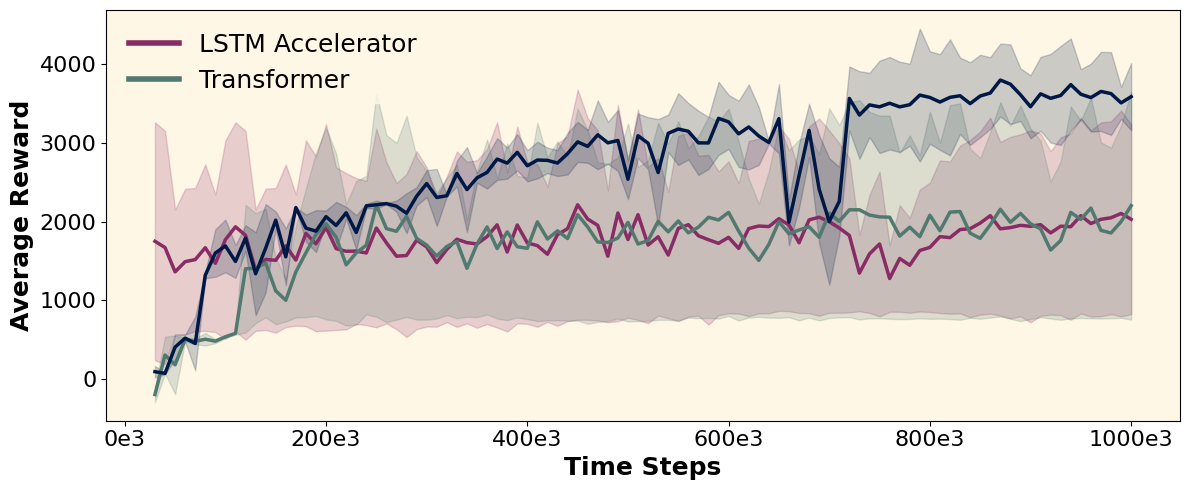

In [ ]:
# ========= Отрисовка графика ============
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('#fff7e6')

# MDP_PRETRAINED (сплошные линии)
line1, = ax.plot(mlp2_s, mean_tr, label='Acelerated Transformer', color='#892b64', linewidth=2.5)
ax.fill_between(mlp2_s, mean_tr - std_tr, mean_tr + std_tr, color='#892b64', alpha=0.2)

line2, = ax.plot(mlp2_s, mean_lstm, label='LSTM From Scratch', color='#52796f', linewidth=2.5)
ax.fill_between(mlp2_s, mean_lstm - std_lstm, mean_lstm + std_lstm, color='#52796f', alpha=0.2)

line2, = ax.plot(mlp2_s, mean_mlp, label='MLP From Scratch', color='#001845', linewidth=2.5)
ax.fill_between(mlp2_s, mean_mlp - std_mlp, mean_mlp + std_mlp, color='#001845', alpha=0.2)


# ===== Оформление графика =====
ax.set_xlabel("Time Steps", fontsize=18, weight='bold')
ax.set_ylabel("Average Reward", fontsize=18, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x/1e3)}e3"))

# Легенда без рамки, с увеличенным шрифтом и жирными линиями
legend = ax.legend(
    handles=[
        plt.Line2D([0], [0], color='#892b64', linewidth=4, label='LSTM Accelerator'),
        plt.Line2D([0], [0], color='#52796f', linewidth=4, label='Transformer'),
        plt.Line2D([0], [0], color='#52796f', linewidth=4, label='Transformer')
    ],
    loc='upper left',
    fontsize=18,
    frameon=True
)
legend.get_frame().set_facecolor('#fff7e6')
legend.get_frame().set_edgecolor('#fff7e6')  # Цвет рамки как у фона, чтобы была "невидимой"

plt.tight_layout()
plt.show()

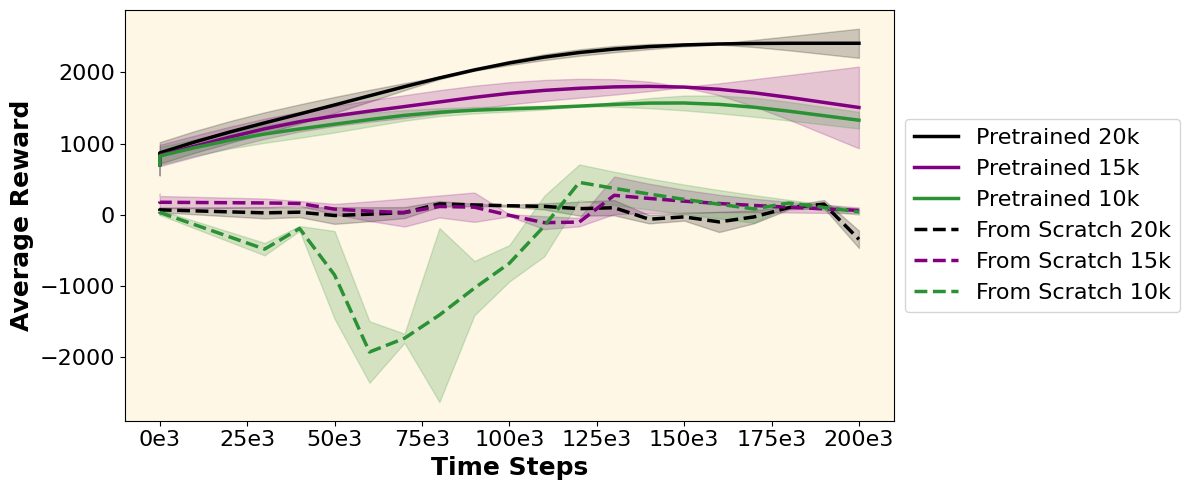

In [26]:
# ========= Отрисовка графика ============
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('#fff7e6')

# Цвета (одинаковые для одного размера буфера)
color_4k   = 'crimson'
color_5k   = 'mediumseagreen'
color_8k   = 'darkblue'
color_10k  = 'orange'
color_15k  = 'purple'
color_1M   = 'black'

# MDP_PRETRAINED (сплошные линии)
#ax.plot(s_4k_1, mean_4k, label='Pretrained 4k', color=color_4k, linewidth=2.5)
#ax.fill_between(s_4k_1, mean_4k - std_4k, mean_4k + std_4k, color=color_4k, alpha=0.2)

#ax.plot(s_5k_1, mean_5k, label='Pretrained 5k', color=color_5k, linewidth=2.5)
#ax.fill_between(s_5k_1, mean_5k - std_5k, mean_5k + std_5k, color=color_5k, alpha=0.2)

#ax.plot(s_8k_1, mean_8k, label='Pretrained 8k', color=color_8k, linewidth=2.5)
#ax.fill_between(s_8k_1, mean_8k - std_8k, mean_8k + std_8k, color=color_8k, alpha=0.2)

ax.plot(s_1M_2, mean_1M, label='Pretrained 20k', color=color_1M, linewidth=2.5)
ax.fill_between(s_1M_2, mean_1M - std_1M, mean_1M + std_1M, color=color_1M, alpha=0.2)

ax.plot(s_15k_2, mean_15k, label='Pretrained 15k', color=color_15k, linewidth=2.5)
ax.fill_between(s_15k_2, mean_15k - std_15k, mean_15k + std_15k, color=color_15k, alpha=0.2)

ax.plot(s_10k_2, mean_10k, label='Pretrained 10k', color='#2a9134', linewidth=2.5)
ax.fill_between(s_10k_2, mean_10k - std_10k, mean_10k + std_10k, color='#2a9134', alpha=0.2)





# MDP_FROM_SCRATCH (пунктирные линии)



ax.plot(s_10k_fs_1, mean_10k_fs, label='From Scratch 20k', color='black', linewidth=2.5, linestyle='--')
ax.fill_between(s_10k_fs_1, mean_10k_fs - std_10k_fs, mean_10k_fs + std_10k_fs, color='black', alpha=0.2)

ax.plot(s_15k_fs_2, mean_15k_fs, label='From Scratch 15k', color=color_15k, linewidth=2.5, linestyle='--')
ax.fill_between(s_15k_fs_2, mean_15k_fs - std_15k_fs, mean_15k_fs + std_15k_fs, color=color_15k, alpha=0.2)


ax.plot(s_4k_fs_1, mean_4k_fs, label='From Scratch 10k', color='#2a9134', linewidth=2.5, linestyle='--')
ax.fill_between(s_4k_fs_1, mean_4k_fs - std_4k_fs, mean_4k_fs + std_4k_fs, color='#2a9134', alpha=0.2)

#ax.plot(s_5k_fs_1, mean_5k_fs, label='From Scratch 5k', color=color_5k, linewidth=2.5, linestyle='--')
#ax.fill_between(s_5k_fs_1, mean_5k_fs - std_5k_fs, mean_5k_fs + std_5k_fs, color=color_5k, alpha=0.2)

#ax.plot(s_8k_fs_1, mean_8k_fs, label='From Scratch 8k', color=color_8k, linewidth=2.5, linestyle='--')
#ax.fill_between(s_8k_fs_1, mean_8k_fs - std_8k_fs, mean_8k_fs + std_8k_fs, color=color_8k, alpha=0.2)


#ax.plot(s_1M_fs_1, mean_1M_fs, label='From Scratch 1M', color=color_1M, linewidth=2.5, linestyle='--')
#ax.fill_between(s_1M_fs_1, mean_1M_fs - std_1M_fs, mean_1M_fs + std_1M_fs, color=color_1M, alpha=0.2)

# ===== Оформление графика =====
ax.set_xlabel("Time Steps", fontsize=18, weight='bold')
ax.set_ylabel("Average Reward", fontsize=18, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x/1e3)}e3"))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

plt.tight_layout()
plt.show()

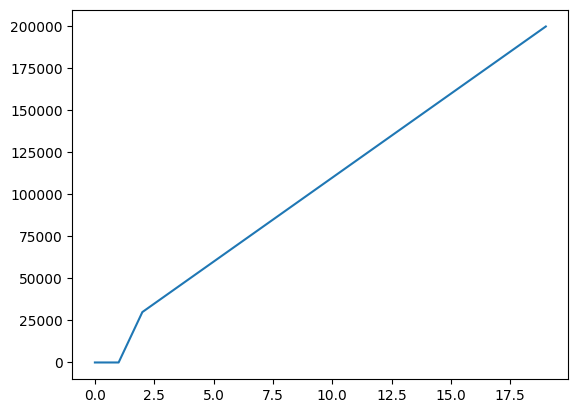

In [25]:
plt.plot(s_4k_fs_2)